# *QuantNbody* tutorials : spin operators and fermionic Hamiltonians 

**Dr. Saad Yalouz**

**Laboratoire de Chimie Quantique de Strasbourg, France**

**July 2022**

In this QuantNBody tutorial, we will focus on the construction of spin operators like $S_2$ and $S_z$ and ab initio electronic structure Hamiltonians $H$. We will show how easily we can build these operators and use them practically.

Let us first import our package and some additional libraries

In [1]:
import quantnbody as qnb
import numpy as np
import scipy
import pyscf
import math
from pyscf import gto, scf, ao2mo, mcscf, fci 

## Electronic strcuture Hamiltonian

The ab initio electronic structure Hamiltonian describes how a collection of $N_e$ electrons rearrange around a set of positively charged nuclei in a molecule. This operator is defined like:

$$ H = \sum_{p,q} h_{pq} \hat{E}_{pq} + \frac{1}{2} \sum_{pqrs} g_{pqrs} \hat{e}_{pqrs} + \mathcal{E}_{nuc.\ rep.}$$

where we have the one- and two-electron integrals $h_{pq}$ and $g_{pqrs}$ (and the nuclear repulsion energy $\mathcal{E}_{nuc.\ rep.}$) associated to the one- and two-electron spin-free excitation operators defined like

$$ E_{pq} = \sum_\sigma a^\dagger_{p,\sigma}a_{q,\sigma} $$

and 

$$ e_{pqrs} = E_{pq}E_{rs} - \delta_{rs} E_{ps} .$$

Here again, we see that all these operators can be defined in terms of the $a_{p,\sigma}^\dagger a_{q,\tau}$ operators. 

Below we show how to create such Hamiltonian for the $H_4$ molecule in the STO-3G basis, and how to compute a ground state potential energy surface easily. In this case, we need to get access to the electronci integrals of the system. We use for this PySCF but note that Psi4 could have been used too !

First we build the essential many-body basis and a_Dagger_a operators

In [2]:
N_elec = N_MO = 4 # Number of MOs and electrons in the system

nbody_basis = qnb.fermionic.tools.build_nbody_basis( N_MO, N_elec ) 
a_dagger_a  = qnb.fermionic.tools.build_operator_a_dagger_a( nbody_basis )  

Then we can build the PES of the molecule with a loop

In [3]:
list_theta = np.linspace(num = 30, start=20. * np.pi/180., stop=160. * np.pi/180., endpoint=True) 
E_HF  = []
E_FCI = []
E_FCI_me = []

N_elec = N_MO = 4
dim_H  = math.comb( 2*N_MO, N_elec )

nbody_basis = qnb.fermionic.tools.build_nbody_basis( N_MO, N_elec )
  
MAX_ROOT = 15

dim_parameter = len(list_theta)
Energies_FCI    = np.zeros((dim_parameter,MAX_ROOT))
Energies_FCI_me = np.zeros((dim_parameter,dim_H)) 

a_dagger_a  = qnb.fermionic.tools.build_operator_a_dagger_a(nbody_basis)
S_2, S_plus, S_z =  qnb.fermionic.tools.build_s2_sz_splus_operator(a_dagger_a)
# for r in tqdm(list_r):
elem = 0
for theta in (list_theta): 
    r = 1.
     
    XYZ_geometry = """ H   {0}   {1}  0.
                       H   {0}  -{1}  0. 
                       H  -{0}   {1}  0.
                       H  -{0}  -{1}  0.  """.format( r*np.cos(theta/2.), r*np.sin(theta/2.) ) 
     
    mol = gto.Mole()
    mol.build( atom     = XYZ_geometry,  # in Angstrom
               basis    = 'STO-3G',
               symmetry = False,
               spin     = 0,
               verbose  = 0)

    mf = scf.RHF(mol)
    print('      ', end='')
    mf.kernel() 
    FCI_solver = pyscf.fci.FCI( mf, mf.mo_coeff  )  
    FCI_solver = fci.addons.fix_spin_(FCI_solver, ss=0, shift=10 ) 
    
    FCI_solver.nroots = MAX_ROOT
    E_FCI_pyscf, Wfn_FCI = FCI_solver.kernel()           
    h_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff,
                           mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'),
                           mf.mo_coeff) 
    g_MO  = ao2mo.kernel( mol, mf.mo_coeff )
    g_MO  = ao2mo.restore('s1', g_MO, N_MO)
 

    E_rep_nuc = mol.energy_nuc()                  # Nuclei repuslion energy
 
    H           = qnb.fermionic.tools.build_hamiltonian_quantum_chemistry( h_MO,
                                                                   g_MO,
                                                                   nbody_basis,
                                                                   a_dagger_a )  
    eig_energies, eig_vectors =  np.linalg.eigh( H.A ) 
    E_FCI_me += [ E_rep_nuc + eig_energies[0] ]
    
    Energies_FCI_me[elem,:] = [ E_rep_nuc + eig_energies[p]  for p in range(dim_H) ] 
    
    Energies_FCI[elem,:] = E_FCI_pyscf
    
    elem += 1 

### Plotting the resulting $H_4$ PES

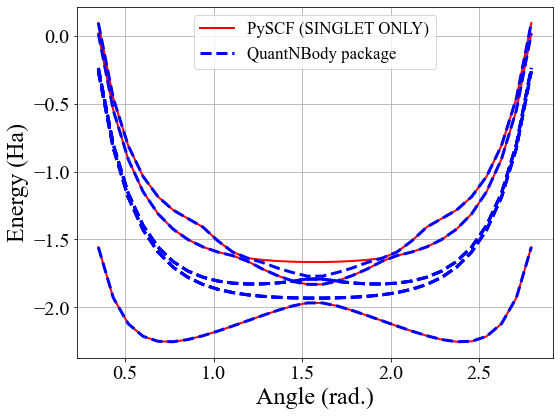

In [4]:
import matplotlib.pyplot as plt

plt.rc('font',  family='serif')
plt.rc('font',  serif='Times New Roman')
plt.rc('font',  size='14') 
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large') 
plt.rc('lines', linewidth='2') 

# Plotting the resulting energies
fig, ( ax1 ) = plt.subplots( nrows=1, ncols=1, figsize=(8, 6)  ) 
for i in range(3):
    if i ==0:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red' , label='PySCF (SINGLET ONLY)' ) 
    else:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red'   ) 
for i in range(9):
    if i ==0: 
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--', lw=3 , label='QuantNBody package'    )  
    else:
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--', lw=3   ) 
ax1.grid()


ax1.set_ylabel('Energy (Ha)', size=24)
ax1.set_xlabel('Angle (rad.)', size=24)
ax1.legend(fontsize='large', ncol=1)

plt.tight_layout()

plt.savefig('PES_H4_ring.pdf')
  
plt.show()
 
 

We see here that QuantNBody produces more state than PySCF restricted to singlet. This is linked to the spin symmetries which has not been defined. As a results, we find here all the states including singlet, triplet, quintet etc. In the following we show hoe to build spin operator and restrcited our calculation to particular symmetries.

## Building spin operators to check the spin symmetry of the states

With QuantNBdoy, one can easily build spin operators as the latter are also naturally defined with $a^\dagger a$ elementary bricks. For example, we can build the global $\hat{S}_2$ operator

$$ \hat{S}_2 = S_+ S_- + S_Z(S_Z-1) ,$$

and the $S_z$ contribution

$$ \hat{S}_Z =  \sum_p ( a^\dagger_{p,\alpha} a_{p,\alpha} - a^\dagger_{p,\beta} a_{p,\beta} ) , $$

and the spin creation operator

$$ \hat{S}_+ = \sum_p a^\dagger_{p,\alpha} a_{p,\beta} $$
 
as we know that $\hat{S}_- = \hat{S}_+^\dagger$.

Below we show how to generate the three matrix operators with a single pre-made function.

In [5]:
S_2, S_z, S_plus =  qnb.fermionic.tools.build_s2_sz_splus_operator(a_dagger_a) # <=== FCT IN THE PACKAGE

We can the use the $\hat{S}_2$ operator to check the spin symmetry of the state produced by the QuantNBody. For this, nothing more simple : we compute the averaged value of this operator for the 10 first eigenstates such that


$$ \langle \hat{S}_2 \rangle_\Psi \equiv  \langle \Psi | \hat{S}_2 | \Psi\rangle   $$ 

We show how to do that below.

In [6]:
print( 'Checking the value of S_2 for the 10 first eigenstates produced by QuantNBody ' )
for i in range(10):
    print('Eigenstate #{} '.format(i) ,  eig_vectors[:,i].T @ S_2 @ eig_vectors[:,i])

Checking the value of S_2 for the 10 first eigenstates produced by QuantNBody 
Eigenstate #0  -9.284507480644949e-21
Eigenstate #1  1.9999999999999967
Eigenstate #2  2.0000000000000018
Eigenstate #3  1.9999999999999982
Eigenstate #4  2.0000000000000036
Eigenstate #5  2.0000000000000013
Eigenstate #6  2.000000000000001
Eigenstate #7  1.8098057182645935e-29
Eigenstate #8  7.52936789914116e-29
Eigenstate #9  2.0000000000000018


Indeed ! We see here that the states generated are not all singlets, e.g. from #1 to #6 we have triplets :/ ... 

To correct this, in QuantNBody we implemented a spin-penalty technique. The idea is here to augment the Hamiltonian of a system like

$$ \hat{H} \longrightarrow \hat{H} + penalty \times (\hat{S}_2 - s_2^{target})^2. $$

Redefining the Hamiltonian like this will change the spectrum of the operator such that every eigenstates $| \Psi \rangle$ which don't have a specific spin symmetry such that

$$ \langle \Psi  | \hat{S}_2 | \Psi \rangle = s_2^{target}$$

will take an "effective" positive energy penalty which will thus shifts the state upper in the spectrum. The penalty term is  chosen to be deliberatly large to ensure that these states are well discared. The value of the spin symmetry targeted $s_2^{target}$ has to be defined by the user. 

This extension has been implemented for every fermionic Hamitlonian (model or ab initio ones). We show below the additional arguments we have to provide to the Hamiltonian function to generate this penalty term and thus obtain singlet in $H_4$. 

In [7]:
import numpy as np
from tqdm import tqdm
import quantnbody as qnb
import math
import pyscf 
from pyscf import gto, scf, ao2mo, mcscf, fci
 
list_theta = np.linspace(num = 30, start=20. * np.pi/180., stop=160. * np.pi/180., endpoint=True) 
E_HF  = []
E_FCI = []
E_FCI_me = []

N_elec = N_MO = 4
dim_H  = math.comb( 2*N_MO, N_elec )

nbody_basis = qnb.fermionic.tools.build_nbody_basis( N_MO, N_elec )
  
MAX_ROOT = 15

dim_parameter = len(list_theta)
Energies_FCI    = np.zeros((dim_parameter,MAX_ROOT))
Energies_FCI_me = np.zeros((dim_parameter,dim_H)) 

a_dagger_a  = qnb.fermionic.tools.build_operator_a_dagger_a(nbody_basis)
S_2, S_plus, S_z =  qnb.fermionic.tools.build_s2_sz_splus_operator(a_dagger_a)
# for r in tqdm(list_r):
elem = 0
for theta in (list_theta): 
    r = 1.
     
    XYZ_geometry = """ H   {0}   {1}  0.
                       H   {0}  -{1}  0. 
                       H  -{0}   {1}  0.
                       H  -{0}  -{1}  0.  """.format( r*np.cos(theta/2.), r*np.sin(theta/2.) ) 
     
    mol = gto.Mole()
    mol.build( atom     = XYZ_geometry,  # in Angstrom
               basis    = 'STO-3G',
               symmetry = False,
               spin     = 0,
               verbose  = 0 )

    mf = scf.RHF( mol )  
    mf.kernel() 
    FCI_solver = pyscf.fci.FCI( mf, mf.mo_coeff  )  
    FCI_solver = fci.addons.fix_spin_(FCI_solver, ss=0, shift=10 ) 
    
    FCI_solver.nroots = MAX_ROOT
    E_FCI_pyscf, Wfn_FCI = FCI_solver.kernel()           
    
    h_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff,
                           mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc'),
                           mf.mo_coeff) 
    g_MO  = ao2mo.kernel( mol, mf.mo_coeff )
    g_MO  = ao2mo.restore('s1', g_MO, N_MO)
 

    E_rep_nuc = mol.energy_nuc()                  # Nuclei repuslion energy
 
    H           = qnb.fermionic.tools.build_hamiltonian_quantum_chemistry( h_MO,
                                                                   g_MO,
                                                                   nbody_basis,
                                                                   a_dagger_a,
                                                                   S_2 = S_2,    # <=== Here : S_2 operator
                                                                   S_2_target=0) # <=== Here : spin symmetry targeted
    eig_energies, eig_vectors =  np.linalg.eigh( H.A ) 
    E_FCI_me += [ E_rep_nuc + eig_energies[0] ]
    
    Energies_FCI_me[elem,:] = [ E_rep_nuc + eig_energies[p]  for p in range(dim_H) ] 
    
    Energies_FCI[elem,:] = E_FCI_pyscf
     
    
    elem += 1 

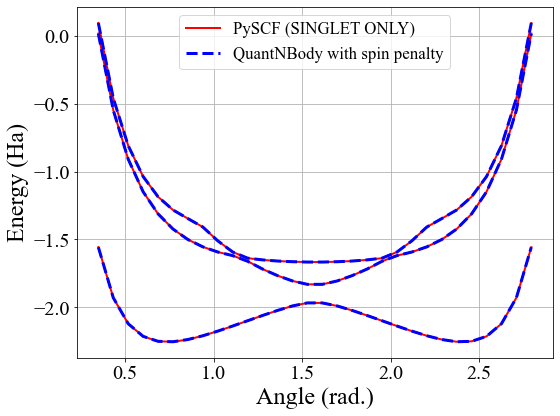

In [10]:
import matplotlib.pyplot as plt

plt.rc('font',  family='serif')
plt.rc('font',  serif='Times New Roman')
plt.rc('font',  size='14') 
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large') 
plt.rc('lines', linewidth='2') 

# Plotting the resulting energies
fig, ( ax1 ) = plt.subplots( nrows=1, ncols=1, figsize=(8, 6)  ) 
for i in range(3):
    if i ==0:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red' , label='PySCF (SINGLET ONLY)' ) 
    else:
        ax1.plot( list_theta, Energies_FCI[:,i], color='red'   ) 
for i in range(3):
    if i ==0: 
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--' , lw=3, label='QuantNBody with spin penalty'    )  
    else:
        ax1.plot( list_theta, Energies_FCI_me[:,i], color='blue', ls='--' , lw=3  ) 
 
ax1.grid()

ax1.set_ylabel('Energy (Ha)', size=24)
ax1.set_xlabel('Angle (rad.)', size=24)
ax1.legend(fontsize='large', ncol=1)

plt.tight_layout()

plt.savefig('PES_H4_ring.pdf')
  
plt.show()
 
 

Congrats ! Here we have totally solved the problem: the lowest states states given by our code are indeed singlet ! To check this we can compute again the averaged $\langle S_2 \rangle$ over the few first eigenstates as shown below.

In [9]:
print( 'Checking the value of S_2 for the 10 first eigenstates produced by QuantNBody ' )
for i in range(10):
    print('Eigenstate #{} '.format(i) ,  eig_vectors[:,i].T @ S_2 @ eig_vectors[:,i])

Checking the value of S_2 for the 10 first eigenstates produced by QuantNBody 
Eigenstate #0  3.851859842609805e-33
Eigenstate #1  6.941457850391153e-31
Eigenstate #2  8.516587868383569e-31
Eigenstate #3  5.606339228213789e-31
Eigenstate #4  9.475714438686259e-31
Eigenstate #5  3.56815220977292e-17
Eigenstate #6  1.4298263821403163e-30
Eigenstate #7  7.737259283015347e-31
Eigenstate #8  2.4865760326277872e-17
Eigenstate #9  4.7598027610679445e-30
